In [4]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Libraries

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy as ACC

from torchsummary import summary

import pytorch_lightning as pl

1    322596
0    296444
Name: Target, dtype: int64


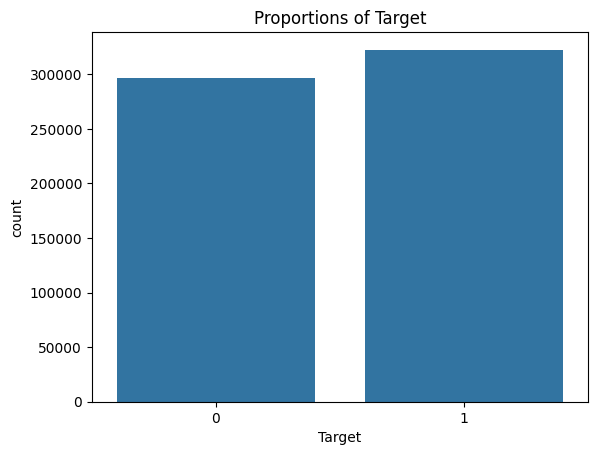

,open,high,low,close,volume,Name,Target,Day,Month,Year
0,15.07,15.12,14.63,14.75,8407500,1,0,0,1,0
1,14.89,15.01,14.26,14.46,8882000,1,0,1,1,0
2,14.45,14.51,14.10,14.27,8126000,1,1,3,1,0
3,14.30,14.94,14.25,14.66,10259500,1,0,4,1,0
4,14.94,14.96,13.16,13.99,31879900,1,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...
619035,76.84,78.27,76.69,77.82,2982259,504,0,2,1,5
619036,77.53,78.12,76.73,76.78,2595187,504,0,0,1,5
619037,76.64,76.92,73.18,73.83,2962031,504,0,1,1,5
619038,72.74,74.56,72.13,73.27,4924323,504,1,3,1,5


In [5]:
class Load_Preprocess():
    def __init__(self, path="all_stocks_5yr.csv"):
        self.df = pd.read_csv(path)
        self.df['Target'] = (self.df['close'].shift(-1) > self.df['close']).astype(int)
        self.Target_proportions()

    def Target_proportions(self):
        print(self.df['Target'].value_counts())
        sns.countplot(x=self.df['Target']).set_title('Proportions of Target')
        plt.show()

    def Preprocessing(self):
        #----------------Convert date column------------------------------------
        self.df = self.df.dropna()
        self.df = self.df.astype({'date':'datetime64[ns]'})
        self.df['Day'] = self.df['date'].dt.day_name()
        self.df['Month'] = self.df['date'].dt.month
        self.df['Year'] = self.df['date'].dt.year
        # Drop date
        self.df.drop('date', axis = 1, inplace = True)

        #----------------Encoding data------------------------------------------
        cate_cols = self.df[['Day', 'Month', 'Year', 'Name']]
        le = LabelEncoder()
        for col in cate_cols:
            self.df[col] = le.fit_transform(self.df[col])

        #----------------Splitting features and label---------------------------
        X = self.df.drop('Target', axis = 1).to_numpy()
        y = self.df['Target'].to_numpy()

        #----------------Scale the the features---------------------------------
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

        #----------------Splitting data-----------------------------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


        return X_train, X_val, X_test, y_train, y_val, y_test

LP = Load_Preprocess()
X_train, X_val, X_test, y_train, y_val, y_test = LP.Preprocessing()
LP.df

In [6]:
X_train.shape, y_train.shape, X_val.shape, X_test.shape, y_val.shape, y_test.shape

((495223, 9), (495223,), (61903, 9), (61903, 9), (61903,), (61903,))

In [7]:
class SAP_500(Dataset):
    def __init__(self, Features, Labels):
        self.features = Features
        self.labels = Labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y = self.features[idx], self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

train_data = SAP_500(X_train, y_train)
val_data = SAP_500(X_val, y_val)
test_data = SAP_500(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [8]:
train_data.__len__(), val_data.__len__(), test_data.__len__()

(495223, 61903, 61903)

In [9]:
train_data.__getitem__(0)[0].shape

torch.Size([9])

In [10]:
class SAP_Classifier_L(pl.LightningModule):
    def __init__(self):
        super(SAP_Classifier_L, self).__init__()
        self.hidden1 = nn.Linear(9, 512)
        self.hidden2 = nn.Linear(512, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.hidden4 = nn.Linear(128, 64)
        self.hidden5 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 2)

        self.activation = nn.LeakyReLU(0.25)

    def forward(self, x):
        out = self.activation(self.hidden1(x))
        out = self.activation(self.hidden2(out))
        out = self.activation(self.hidden3(out))
        out = self.activation(self.hidden4(out))
        out = self.activation(self.hidden5(out))

        out = self.output(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch # get portion from dataset
        y_hat = self.forward(x) # predict
        loss = nn.CrossEntropyLoss()(y_hat.squeeze(), y.long()) # compute the error or diffrences
        acc = ACC(y_hat, y, task="multiclass", num_classes=2)

        self.log('Train_loss', loss, prog_bar=True) # save to the working memory to visulize it later
        self.log('Train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat.squeeze(), y.long())
        acc = ACC(y_hat, y, task="multiclass", num_classes=2)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [11]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Model = SAP_Classifier_L().to(device)
print(Model)
device

SAP_Classifier_L(
  (hidden1): Linear(in_features=9, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=128, bias=True)
  (hidden4): Linear(in_features=128, out_features=64, bias=True)
  (hidden5): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=2, bias=True)
  (activation): LeakyReLU(negative_slope=0.25)
)


'cuda'

In [12]:
summary(Model, input_size=(1, 9))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]           5,120
         LeakyReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
         LeakyReLU-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
         LeakyReLU-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 64]           8,256
         LeakyReLU-8                [-1, 1, 64]               0
            Linear-9                [-1, 1, 32]           2,080
        LeakyReLU-10                [-1, 1, 32]               0
           Linear-11                 [-1, 1, 2]              66
Total params: 179,746
Trainable params: 179,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [13]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(Model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | hidden1    | Linear    | 5.1 K 
1 | hidden2    | Linear    | 131 K 
2 | hidden3    | Linear    | 32.9 K
3 | hidden4    | Linear    | 8.3 K 
4 | hidden5    | Linear    | 2.1 K 
5 | output     | Linear    | 66    
6 | activation | LeakyReLU | 0     
-----------------------------------------
179 K     Trainable params
0         Non-trainable params
179 K     Total params
0.719     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
